<a href="https://colab.research.google.com/github/JamesChung821/python/blob/master/%E3%80%8Ck_means_on_found_atoms_cracked_image_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alex Belianinov
#Sandia National Laboratory
#Ion Beam Laboratory

# K-means Clustering on Local Neighborhoods in Atomically Resolved Images

# Setting up the Notebook

In [ ]:
#%% Import necessary Python libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import cv2

In [ ]:
# from scipy.misc import imsave
from skimage.io import imsave

In [ ]:
from sklearn.neighbors import NearestNeighbors
import math
from scipy.cluster.vq import  whiten
from sklearn.cluster import KMeans

# Tunable Parameters

In [ ]:
#Image location for a raw image file (text, tiff, png, etc.)

#set the image_path to the current working directory no matter who is using this file
!wget -O cracked_clean_image.png https://drive.google.com/u/0/uc?id=1MKVdXwOL_S6Y3ja-n_ZOE90vzceMnSMS&export=download
thresh_const = 6 #Constant for thresholding
border = 1 #How many pixels to cut off the clean image before atom finding

Exterminate = 1 #On/Off Switch for eliminating edge atoms from atom clustering
cut_val = 25 #Pixels with to eliminate from the edge of each image for atom classification
num_neighbors = 6 #Number of neighbors to designate for the atom classification
num_cluster = 4 #Number of clusters for KMeans classification

markers = {'o', '+', '*', 'x', 's', 'd', '^', 'v', '>', '<', 'p', 'h'}
color_ops = ['b','g', 'r', 'c', 'm', 'y', 'w', '#3399ff', '#660066', '#4080bf',\
              '#00ffcc', '#aa80ff', '#ff9933', '#1a1aff','#b38600', ' #77b300']
classification_cell = ['angles', 'length']
classification = [1, 2] #Designate 0, 1 for angles or 1,2 for length

--2021-07-24 18:46:18--  https://drive.google.com/u/0/uc?id=1MKVdXwOL_S6Y3ja-n_ZOE90vzceMnSMS
Resolving drive.google.com (drive.google.com)... 74.125.195.102, 74.125.195.139, 74.125.195.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ufjs6nfv34oe380i379aro30teo2ore4/1627152375000/06954711203411773855/*/1MKVdXwOL_S6Y3ja-n_ZOE90vzceMnSMS [following]
--2021-07-24 18:46:19--  https://doc-0g-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ufjs6nfv34oe380i379aro30teo2ore4/1627152375000/06954711203411773855/*/1MKVdXwOL_S6Y3ja-n_ZOE90vzceMnSMS
Resolving doc-0g-2k-docs.googleusercontent.com (doc-0g-2k-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0g-2k-docs.googleusercontent.com (doc-0g-2k-docs.googleusercontent.com)|74

# Data IO, Visualize Clean Image 

<Figure size 432x288 with 0 Axes>

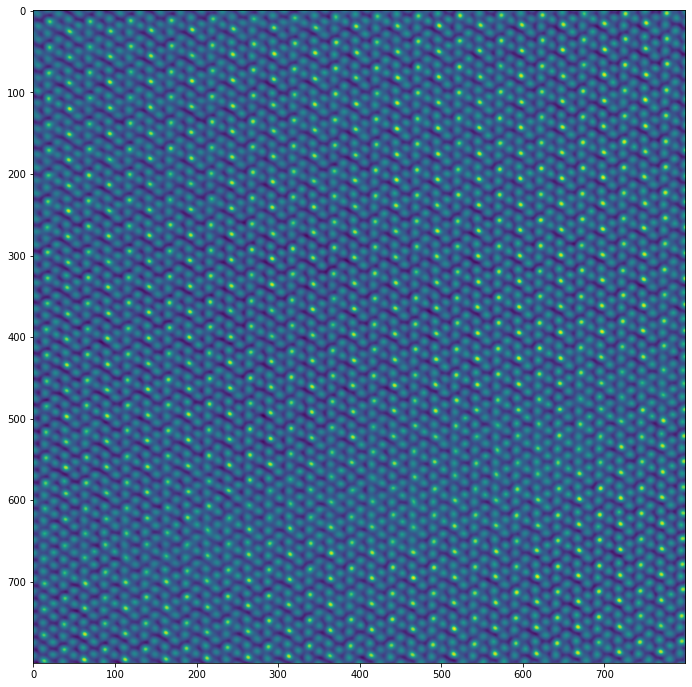

In [ ]:
#%% Read cleaned image. The image in this case is a PCA cleaned image. 
# Apply thresholding function to image to identify atom positions.
img = cv2.imread("cracked_clean_image.png", 0)

#Show the Image
fig = plt.figure()
plt.figure(figsize=(12, 12))
plt.imshow(img)

# Binarize the Image by Thresholding 

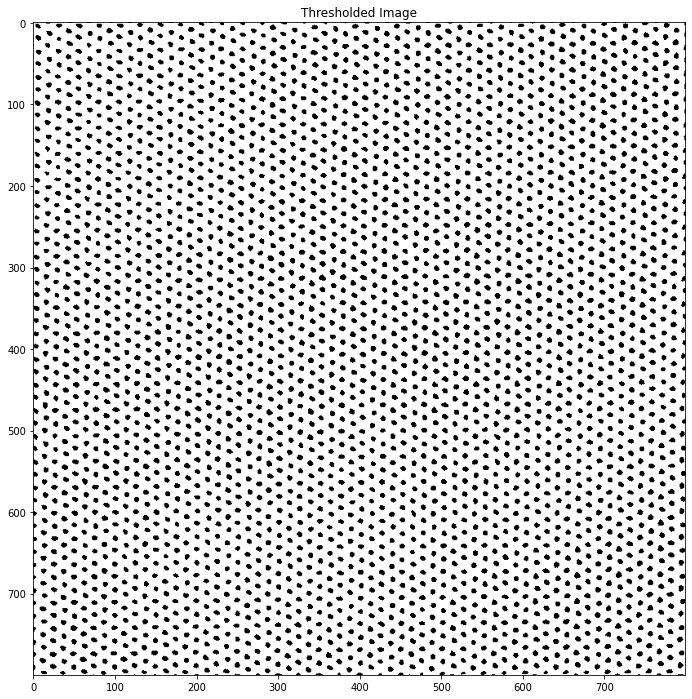

In [ ]:
#Invert image because thresholding removes low intenstity values
img_inv = 255-img 
th = cv2.adaptiveThreshold(img_inv,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY_INV,11,thresh_const)
# Plot Thresholded Image
plt.figure(figsize=(12, 12))
plt.imshow(th, cmap='Greys')
plt.title('Thresholded Image')

# Set border on thresholded image for cropping to find atoms
th_new = th[border:-border,border:-border]

# Find the Atoms and Display Findings Over the Image

## Set the Image Border Size 

In [ ]:
#%% calculate atom center of mass from atom positions. This step finds the atoms.
all_labels = measure.label(th_new)
atom_labels = measure.label(th_new)

num_atoms = np.max(atom_labels)-1
atom_positions = np.zeros(shape=(num_atoms, 2), dtype=np.uint16)

for atom_ind in range(1,num_atoms):
    atom_pixels = np.argwhere(atom_labels == atom_ind)
    atom_positions[atom_ind] = np.mean(atom_pixels, axis=0)

(-0.5, 799.5, 799.5, -0.5)

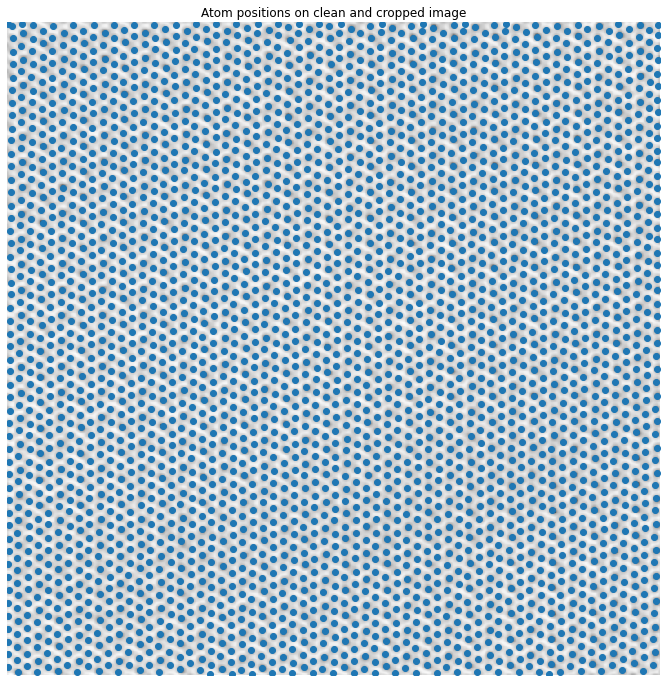

In [ ]:
# Plot the atom positions on the cleaned image
plt.figure(figsize=(12,12))  
plt.imshow(img, cmap='Greys', interpolation='none') 
atom_positions = np.flipud(np.rot90(atom_positions,2)) #to orient atom_positions
                                               #with respect the the cropped image
    
# the border is to compensate the cut off in the previous thresholding step    
plt.scatter(atom_positions[:,0] + border*np.ones(atom_positions.shape[0]), atom_positions[:,1]+ border*np.ones(atom_positions.shape[0]))
# plt.scatter(atom_positions[:,0] , atom_positions[:,1])

plt.title('Atom positions on clean and cropped image')
plt.axis('off')

# Save the Atom Positions & Crop Empty Image Space

In [ ]:
# Saving the atom positions

##folder_path = '/Users/ba8/Desktop/'

#set the image_path to the current working directory no matter who is using this file
import os
folder_path = os.getcwd()

#save atom positions
x_y_positions = np.array(atom_positions, dtype='float64')
atom_path = folder_path + '/atom_positions.txt'
np.savetxt(atom_path, x_y_positions)

#cropped image 
image_cropped = img[border:-border, border:-border]

# Visualize the Cropped Image 

(-0.5, 797.5, 797.5, -0.5)

<Figure size 432x288 with 0 Axes>

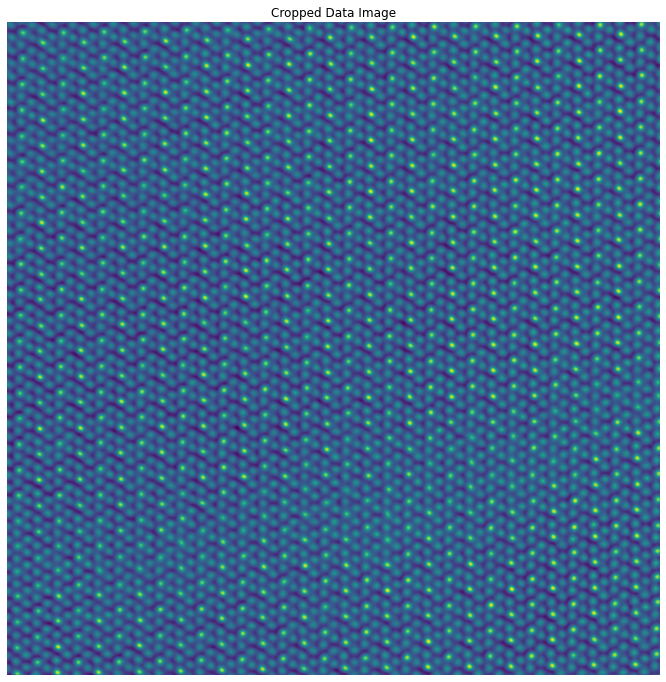

In [ ]:
#%% Preparing for Atom classification
# Get the cropped image for k-means
grayatom = image_cropped

#Show image
plt.figure()
plt.figure(figsize=(12,12))  
plt.imshow(grayatom)
plt.title('Cropped Data Image')
plt.axis('off')

# Eliminate Edge Atoms as Centers and Leave them as Neighbors

In [ ]:
cut_x, cut_y = grayatom.shape

atoms_x, atoms_y = x_y_positions[:, 0], x_y_positions[:, 1]
x_y_positions_edge_cut = np.zeros_like(x_y_positions)

# only preserve limited amount of atoms that are in the range of (cut_val , cut_x - cut_val) for both x and y axis
# the border atom is removed
atoms_x_remain = np.logical_and( atoms_x > cut_val , atoms_x < cut_x - cut_val )
atoms_y_remain = np.logical_and( atoms_y > cut_val , atoms_y < cut_y - cut_val )
atoms_remain = np.logical_and(atoms_x_remain, atoms_y_remain)

x_y_positions_edge_cut[atoms_remain] = x_y_positions[atoms_remain]
all_x = x_y_positions_edge_cut[:,0]
all_y = x_y_positions_edge_cut[:,1]

# Find a Specified Number of Nearest Neighbors for All Atoms

In [ ]:
#%%    Finds specified number of neighbors around (x,y) position. Outputs idices
# of all neighbors and distance to them
              
nbrs = NearestNeighbors(n_neighbors=num_neighbors+1, algorithm='brute').fit(x_y_positions)
# distance_vec distance from itself to its n neigbor where the neighbor is described in the full_index
# the first element in each row of full_index is always itself not surprisingly
distance_vec, full_index = nbrs.kneighbors(x_y_positions)

# just remove itself
index = full_index[:,1:] 

In [ ]:
distance_vec.shape, full_index.shape, index.shape

((3278, 7), (3278, 7), (3278, 6))

In [ ]:
full_index[:, 0] # which points to itself

array([   0,    1,    2, ..., 3275, 3276, 3277])

# Visualize a Real Space Neighborhood Spread

In [ ]:
classification_cell, classification

(['angles', 'length'], [1, 2])

In [ ]:
classify_by = classification_cell[classification[0]]

<Figure size 432x288 with 0 Axes>

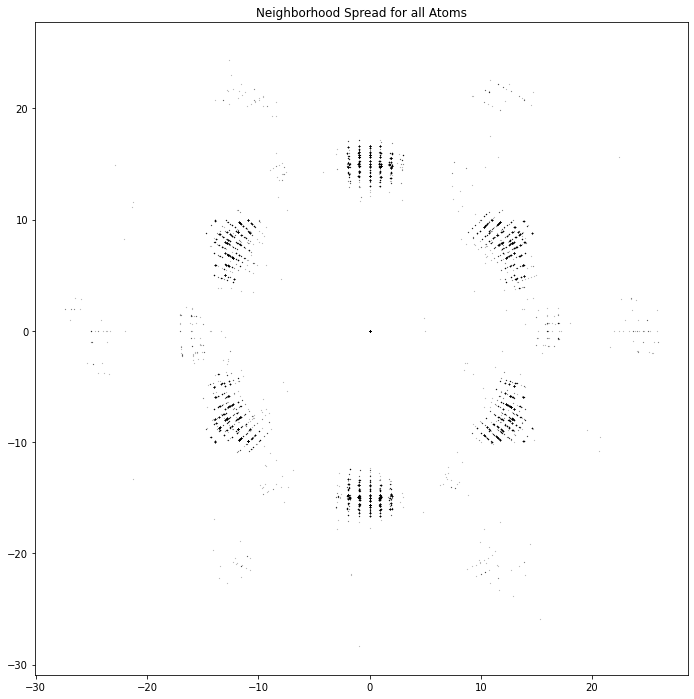

In [ ]:
#%% Neighborhood Histograms

nbr_xy = x_y_positions[index]
# broadcasting is used here, the new dimension would be internally "copied" to the same len of the nbr_xy.shape[1]
nbr_xy_relative = nbr_xy - x_y_positions[:, None, :] # [:,None,:] add a new dimension to the x_y_position (n,m) -> (n,1,m)

nbr_angle = np.arctan2( nbr_xy_relative[:,:,1], nbr_xy_relative[:,:,0] )
nbr_angle_arg_idx = np.argsort( nbr_angle, axis=1 )  
distance_vec_sorted = np.take_along_axis( distance_vec, nbr_angle_arg_idx, axis=-1)
nbr_angle_sorted =  np.take_along_axis( nbr_angle, nbr_angle_arg_idx, axis=-1)

distance_x_sorted = distance_vec_sorted * np.cos( nbr_angle_sorted )
distance_y_sorted = distance_vec_sorted * np.sin( nbr_angle_sorted ) * -1

# it plots the displacement from the origin to its neighbor
plt.figure()
plt.figure(figsize=(12,12)) 
plt.scatter(distance_x_sorted, distance_y_sorted, color = 'k', s=.01)
plt.axis('square')
plt.title('Neighborhood Spread for all Atoms')

classified_index = nbr_angle_arg_idx
classified_data = nbr_angle_sorted

In [ ]:
if classify_by == 'length':
    nbr_dis = np.linalg.norm( nbr_xy_relative, axis=-1 )
    nbr_dis_arg_idx = np.argsort( nbr_dis, axis=-1 )
    nbr_dis_sorted = np.take_along_axis( nbr_dis, nbr_dis_arg_idx, axis=-1)
    
    classified_index = nbr_dis_arg_idx
    classified_data = nbr_dis_sorted

# Cluster the Neighborhoods & Display Results

(-0.5, 797.5, 797.5, -0.5)

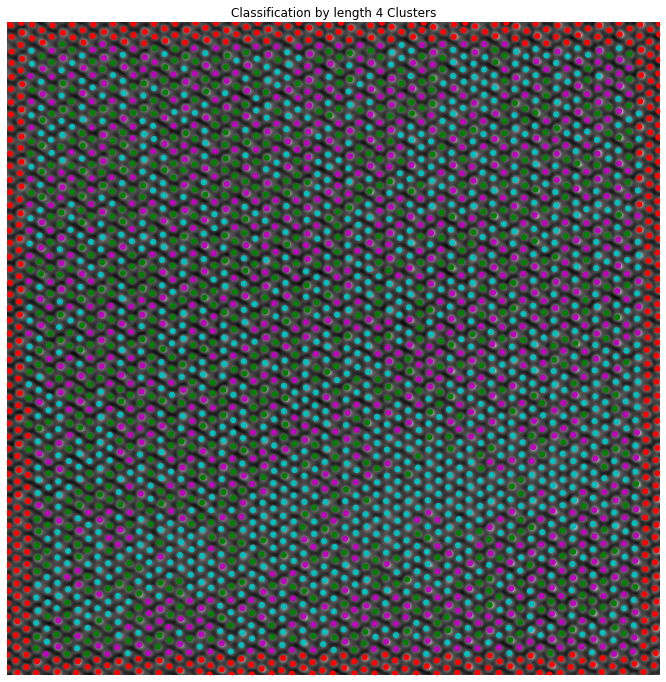

In [ ]:
#%% Sorts into clusters by distance to neighbors and creates a cell with a 
#Point index for each cluter
   
if Exterminate:
    data_mat = classified_data
        
    for g in range(0,int(x_y_positions.shape[0])):
            
        if x_y_positions_edge_cut[g,0] == 0:
            data_mat[g,:] = 0
else:
    data_mat = classified_data
    
analysis_type = 'full data'
    
whiten_data = whiten(data_mat)
# do a kMeans regarding the distance/angle of the NNs
IDX = KMeans(n_clusters= num_cluster, max_iter=1000).fit_predict(whiten_data)
IDX = IDX + 1 #So that we don't divide by 0 later

plt.figure(figsize=(12,12))
plt.scatter(x_y_positions[:,0],x_y_positions[:,1], c= 'k', s=0.5)
plt.axis('off')
plt.imshow(image_cropped, cmap = 'gray')
for n1 in range(1, num_cluster +1):
    plt.scatter(x_y_positions[IDX == n1,0], x_y_positions[IDX == n1, 1], c = color_ops[n1], edgecolors= 'none')

plt.title('Classification by ' + classify_by + ' ' + str(num_cluster) + ' Clusters')
plt.axis('off')

# Visualize Each Cluster and Its Real Space Neighborhood Separately

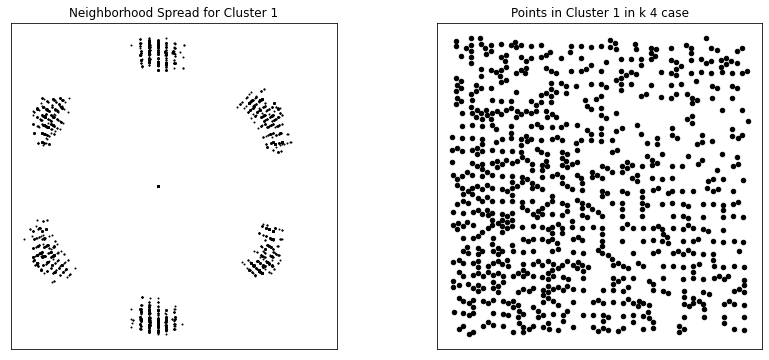

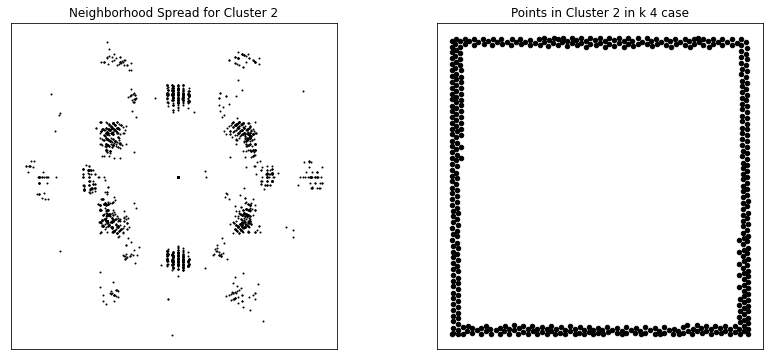

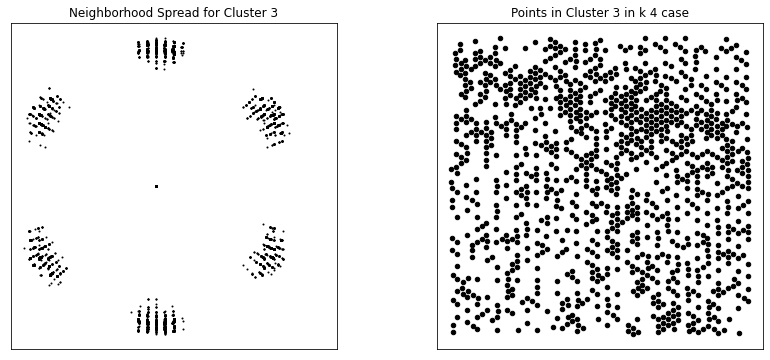

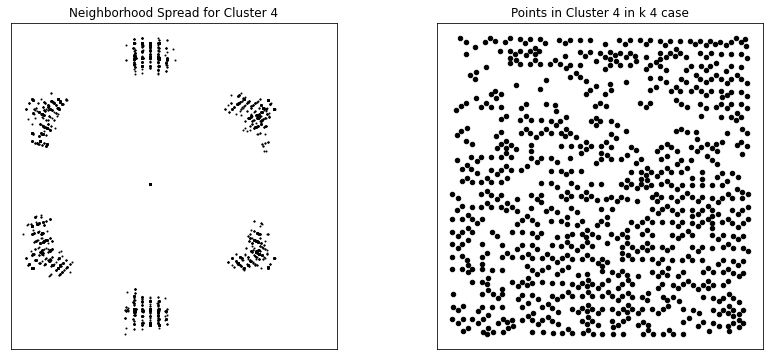

In [ ]:
#%% Individualized Cluster Visualization
num_row, num_col = classified_data.shape

for cluster in range(1,num_cluster+1):    
    h3 = cluster# need to check
    #Plotting Neighborhood Spread for cluster
    fig,axs = plt.subplots(1, 2, figsize=(14,6))
    axs[0].scatter(distance_x_sorted[IDX==cluster,:],distance_y_sorted[IDX==cluster,:], color = 'k', s=1)
    axs[0].axis('square')
    axs[0].set_aspect('equal', 'box')
    axs[0].axes.get_xaxis().set_visible(False)
    axs[0].axes.get_yaxis().set_visible(False)
    axs[0].set_title('Neighborhood Spread for Cluster ' + str(h3))
    
    #Plotting Points in Cluster, the short way
    axs[1].scatter(x_y_positions[IDX==cluster,0],x_y_positions[IDX==cluster,1], color = 'k',s=20)
    axs[1].axis('tight')
    axs[1].axes.get_xaxis().set_visible(False)
    axs[1].axes.get_yaxis().set_visible(False)
    axs[1].set_aspect('equal', 'box')
    axs[1].set_title('Points in Cluster ' + str(h3) + ' in k ' + str(num_cluster) + ' case')
   